In [17]:
%load_ext autoreload
%autoreload 2

import os
import statistics

import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader

import generate_stim_train_data
import lesion
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils

OBSERVER_TYPE = "gaussian"
LESION_MODULE = "F5"
LESION_TYPE = "outputs"
LESION_PCT = 1.0
STIMULATION_TYPE = "gaussian"
ACTIVATION_TYPE = "ReLU"
NUM_NEURONS_PER_MODULE = 100


if OBSERVER_TYPE == "passthrough":
    observer_instance = observer.ObserverPassthrough(NUM_NEURONS_PER_MODULE)
elif OBSERVER_TYPE == "gaussian":
    observer_instance = observer.ObserverGaussian1d(NUM_NEURONS_PER_MODULE, out_dim=35)
else:
    raise ValueError(f"Unrecognized observer type: {OBSERVER_TYPE}")
    
    
if STIMULATION_TYPE == "1to1":
    stimulus = stim.Stimulus1to1(NUM_NEURONS_PER_MODULE, NUM_NEURONS_PER_MODULE)
elif STIMULATION_TYPE == "gaussian":
    # NOTE: can add the num_stim_channels and sigma arg above
    stimulus = stim.StimulusGaussian(35, NUM_NEURONS_PER_MODULE)
else:
    raise ValueError(f"Unrecognized stimulation type: {STIMULATION_TYPE}")

if LESION_TYPE == "outputs":
    lesion_instance = lesion.LesionOutputs(NUM_NEURONS_PER_MODULE,
            LESION_MODULE, LESION_PCT)
elif LESION_TYPE == "none":
    lesion_instance = None
else:
    raise ValueError(f"Unrecognized lesion type: {LESION_TYPE}")

    
RECOVERY = True
RECOVERY_STR = "recovered" if RECOVERY else "notrecovered"

RUN_TYPE = "_".join([str(observer_instance), str(lesion_instance), str(stimulus)])

DATA_DIR = "ben"
MRNN_DIR = "mrnn"
DATA_PATH = os.path.join(DATA_DIR, f"stim_data_brain_{RUN_TYPE}.hdf5")
MODEL_PATH = os.path.join(DATA_DIR, f"ben_model_{ACTIVATION_TYPE}_{RUN_TYPE}.pth")
MRNN_MODEL_PATH = os.path.join(MRNN_DIR, f"mrnn_{str(lesion_instance)}_{RECOVERY_STR}.pth")
BATCH_SIZE = 64


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
if ACTIVATION_TYPE == "ReLU":
    activation = torch.nn.ReLU
elif ACTIVATION_TYPE == "ReTanh":
    activation = utils.ReTanh
else:
    raise ValueError(f"Unrecognized activation type: {ACTIVATION_TYPE}")

In [8]:
# For reference: typical losses for a healthy network
# NOTE: if preds are all 0s, a loss of 0.02 is typical
# NOTE: if RNN activations are all 0s, 0.22 is typical
path = michaels_load.get_default_path()
rnn = mRNN.MichaelsRNN(init_data_path=path)
dataset = mRNN.MichaelsDataset(path)

losses = []
loader = DataLoader(
  dataset, batch_size=64, shuffle=True
)
for i_batch, sampled_batch in enumerate(loader):
    rnn.reset_hidden()

    din, dout = sampled_batch
    batch_size = din.shape[0]
    example_len = din.shape[1]

    preds = torch.empty((batch_size, example_len, rnn.output_dim))
    for tidx in range(example_len):
        cur_in = din[:, tidx, :]
        pred = rnn(cur_in.T)
        preds[:, tidx, :] = pred[:, :]

    loss = torch.nn.MSELoss()(preds, dout)
    losses.append(loss.item())

print(losses)
print(statistics.mean(losses))

[0.0038967328146100044, 0.004182655364274979, 0.00375190656632185, 0.002872718032449484, 0.0037188492715358734, 0.0033399229869246483, 0.0036659196484833956, 0.0035624562297016382]
0.003623895114287734


In [19]:
# NOTE: if we kill the entire network except for 12 neurons in M1, the
#       loss can still be as good as 0.005, which is only ~50% worse than
#       a healthy network!  So: lesions are not intensely powerful after
#       recovery.

mrnn = mRNN.generate(MRNN_MODEL_PATH, stimulus=stimulus, lesion=lesion_instance,
                     recover_after_lesion=RECOVERY)

Mean loss: 0.04315464640967548
Mean loss: 0.01953180623240769
Mean loss: 0.014281788491643965
Mean loss: 0.011223622015677392
Mean loss: 0.009135834290646017
Mean loss: 0.007208215480204672
Mean loss: 0.005792724259663373
Mean loss: 0.005192141397856176
Mean loss: 0.005022267403546721
Mean loss: 0.004878802748862654
Mean loss: 0.004792076535522938
Mean loss: 0.004743202531244606
Mean loss: 0.004722012556158006
Mean loss: 0.00469481258187443
Mean loss: 0.0046943973284214735
Mean loss: 0.004736797709483653
Mean loss: 0.004689808178227395


In [20]:
# Reload, so we can pick up from here
mrnn = mRNN.load_from_file(MRNN_MODEL_PATH, lesion=lesion_instance, stimulus=stimulus)

In [23]:
# Generate the training data for our stimulation model (referred
# to as "brain emulator network", or "BEN")
x = generate_stim_train_data.generate(DATA_PATH, mrnn,
                                      observer_instance=observer_instance,
                                      stim_max_power=4.5)

1622233603.477557 Generating example 0
1622233604.2653255 Generating example 1
1622233605.2915533 Generating example 2
1622233606.1388454 Generating example 3
1622233606.937316 Generating example 4
1622233607.6935678 Generating example 5
1622233608.5894945 Generating example 6
1622233609.4115016 Generating example 7
1622233610.353695 Generating example 8
1622233611.17641 Generating example 9
1622233612.0995564 Generating example 10
1622233613.0225618 Generating example 11
1622233613.746492 Generating example 12
1622233614.5484836 Generating example 13
1622233615.3893685 Generating example 14
1622233616.286108 Generating example 15
1622233617.0774682 Generating example 16
1622233617.9932613 Generating example 17
1622233618.7964122 Generating example 18
1622233619.5774112 Generating example 19
1622233620.3936484 Generating example 20
1622233621.189064 Generating example 21
1622233621.9415774 Generating example 22
1622233622.6388052 Generating example 23
1622233623.4496143 Generating exam

1622233768.8362987 Generating example 200
1622233769.682229 Generating example 201
1622233770.501962 Generating example 202
1622233771.380235 Generating example 203
1622233772.2001119 Generating example 204
1622233772.9352844 Generating example 205
1622233773.754386 Generating example 206
1622233774.567432 Generating example 207
1622233775.417502 Generating example 208
1622233776.1908393 Generating example 209
1622233777.1093807 Generating example 210
1622233777.9803488 Generating example 211
1622233778.8023188 Generating example 212
1622233779.699408 Generating example 213
1622233780.5065038 Generating example 214
1622233781.302097 Generating example 215
1622233782.1876972 Generating example 216
1622233783.03025 Generating example 217
1622233783.9683747 Generating example 218
1622233784.8148382 Generating example 219
1622233785.616011 Generating example 220
1622233786.330437 Generating example 221
1622233787.2634377 Generating example 222
1622233788.0408218 Generating example 223
1622

1622233938.5511358 Generating example 397
1622233939.5125842 Generating example 398
1622233940.4012501 Generating example 399
1622233941.23797 Generating example 400
1622233942.0455074 Generating example 401
1622233942.87141 Generating example 402
1622233943.722559 Generating example 403
1622233944.704844 Generating example 404
1622233945.5320647 Generating example 405
1622233946.3008144 Generating example 406
1622233947.1400537 Generating example 407
1622233948.1311762 Generating example 408
1622233948.973438 Generating example 409
1622233949.891048 Generating example 410
1622233950.7053628 Generating example 411
1622233951.5588982 Generating example 412
1622233952.525071 Generating example 413
1622233953.3660944 Generating example 414
1622233954.1864743 Generating example 415
1622233954.989205 Generating example 416
1622233955.9202268 Generating example 417
1622233956.93328 Generating example 418
1622233957.7922845 Generating example 419
1622233958.6246684 Generating example 420
1622

1622234107.4006193 Generating example 594
1622234108.2182667 Generating example 595
1622234109.0514646 Generating example 596
1622234109.9049788 Generating example 597
1622234110.629589 Generating example 598
1622234111.4581718 Generating example 599
1622234112.212312 Generating example 600
1622234113.2220237 Generating example 601
1622234114.0579393 Generating example 602
1622234114.9295447 Generating example 603
1622234115.755109 Generating example 604
1622234116.593672 Generating example 605
1622234117.3891597 Generating example 606
1622234118.3663282 Generating example 607
1622234119.2113807 Generating example 608
1622234120.000332 Generating example 609
1622234120.843317 Generating example 610
1622234121.7073238 Generating example 611
1622234122.5666237 Generating example 612
1622234123.3637578 Generating example 613
1622234124.183529 Generating example 614
1622234125.0214365 Generating example 615
1622234125.8385704 Generating example 616
1622234126.8277342 Generating example 617

1622234272.9129574 Generating example 791
1622234273.6842515 Generating example 792
1622234274.4337971 Generating example 793
1622234275.2067087 Generating example 794
1622234276.1171365 Generating example 795
1622234277.0023515 Generating example 796
1622234277.791973 Generating example 797
1622234278.733626 Generating example 798
1622234279.6932893 Generating example 799
1622234280.5890741 Generating example 800
1622234281.4203892 Generating example 801
1622234282.3441365 Generating example 802
1622234283.1359282 Generating example 803
1622234283.9315062 Generating example 804
1622234284.7775342 Generating example 805
1622234285.6329086 Generating example 806
1622234286.5226004 Generating example 807
1622234287.3999944 Generating example 808
1622234288.3797233 Generating example 809
1622234289.1089497 Generating example 810
1622234289.9397423 Generating example 811
1622234290.702227 Generating example 812
1622234291.5862336 Generating example 813
1622234292.3386374 Generating example

1622234433.469856 Generating example 988
1622234434.364744 Generating example 989
1622234435.1648152 Generating example 990
1622234436.0103781 Generating example 991
1622234436.8750646 Generating example 992
1622234437.7146962 Generating example 993
1622234438.6670358 Generating example 994
1622234439.5688238 Generating example 995
1622234440.4106805 Generating example 996
1622234441.280355 Generating example 997
1622234441.9967136 Generating example 998
1622234442.8419182 Generating example 999
1622234443.7345092 Generating example 1000
1622234444.5934246 Generating example 1001
1622234445.3969896 Generating example 1002
1622234446.2529912 Generating example 1003
1622234447.0589294 Generating example 1004
1622234447.8862352 Generating example 1005
1622234448.6020882 Generating example 1006
1622234449.3267882 Generating example 1007
1622234450.0266702 Generating example 1008
1622234450.9068909 Generating example 1009
1622234451.6358838 Generating example 1010
1622234452.3265367 Generat

1622234588.372621 Generating example 1180
1622234589.1164882 Generating example 1181
1622234589.9254112 Generating example 1182
1622234590.6569016 Generating example 1183
1622234591.3909132 Generating example 1184
1622234592.1798244 Generating example 1185
1622234593.081871 Generating example 1186
1622234593.9019876 Generating example 1187
1622234594.6576087 Generating example 1188
1622234595.441811 Generating example 1189
1622234596.2394586 Generating example 1190
1622234597.0596406 Generating example 1191
1622234597.8818598 Generating example 1192
1622234598.6005485 Generating example 1193
1622234599.5211656 Generating example 1194
1622234600.4083602 Generating example 1195
1622234601.2359195 Generating example 1196
1622234602.1472633 Generating example 1197
1622234602.951323 Generating example 1198
1622234603.7833824 Generating example 1199
1622234604.512375 Generating example 1200
1622234605.4944174 Generating example 1201
1622234606.3563128 Generating example 1202
1622234607.16413

1622234746.199037 Generating example 1372
1622234747.1131277 Generating example 1373
1622234747.9112258 Generating example 1374
1622234748.8151538 Generating example 1375
1622234749.7867038 Generating example 1376
1622234750.6496363 Generating example 1377
1622234751.5187266 Generating example 1378
1622234752.3604674 Generating example 1379
1622234753.4295902 Generating example 1380
1622234754.2505114 Generating example 1381
1622234755.1070411 Generating example 1382
1622234755.8293903 Generating example 1383
1622234756.7057576 Generating example 1384
1622234757.5102205 Generating example 1385
1622234758.3910525 Generating example 1386
1622234759.1421237 Generating example 1387
1622234759.9278684 Generating example 1388
1622234760.7755456 Generating example 1389
1622234761.613992 Generating example 1390
1622234762.637307 Generating example 1391
1622234763.402503 Generating example 1392
1622234764.3127966 Generating example 1393
1622234765.1255016 Generating example 1394
1622234765.9573

1622234905.031119 Generating example 1564
1622234905.8767314 Generating example 1565
1622234906.6402118 Generating example 1566
1622234907.588105 Generating example 1567
1622234908.2541082 Generating example 1568
1622234909.0509038 Generating example 1569
1622234909.87116 Generating example 1570
1622234910.6111674 Generating example 1571
1622234911.4588716 Generating example 1572
1622234912.1614902 Generating example 1573
1622234912.857921 Generating example 1574
1622234913.7124875 Generating example 1575
1622234914.5296416 Generating example 1576
1622234915.337392 Generating example 1577
1622234916.1866665 Generating example 1578
1622234917.0747497 Generating example 1579
1622234918.034498 Generating example 1580
1622234918.919151 Generating example 1581
1622234919.683517 Generating example 1582
1622234920.366718 Generating example 1583
1622234921.0697556 Generating example 1584
1622234921.9113038 Generating example 1585
1622234922.8337402 Generating example 1586
1622234923.6317654 Ge

1622235060.0559666 Generating example 1756
1622235060.9019794 Generating example 1757
1622235061.6684709 Generating example 1758
1622235062.3795164 Generating example 1759
1622235063.2467937 Generating example 1760
1622235064.002538 Generating example 1761
1622235064.7811446 Generating example 1762
1622235065.6662648 Generating example 1763
1622235066.5188708 Generating example 1764
1622235067.3234847 Generating example 1765
1622235068.0279455 Generating example 1766
1622235068.9590178 Generating example 1767
1622235069.7671266 Generating example 1768
1622235070.4593563 Generating example 1769
1622235071.2138023 Generating example 1770
1622235071.9187675 Generating example 1771
1622235072.6584132 Generating example 1772
1622235073.5709286 Generating example 1773
1622235074.3095162 Generating example 1774
1622235075.184735 Generating example 1775
1622235075.9937449 Generating example 1776
1622235076.8230183 Generating example 1777
1622235077.6948378 Generating example 1778
1622235078.52

1622235215.1060255 Generating example 1948
1622235215.9829345 Generating example 1949
1622235216.8062131 Generating example 1950
1622235217.5535536 Generating example 1951
1622235218.318621 Generating example 1952
1622235219.028201 Generating example 1953
1622235219.9022918 Generating example 1954
1622235220.7140286 Generating example 1955
1622235221.5326223 Generating example 1956
1622235222.4408908 Generating example 1957
1622235223.2589166 Generating example 1958
1622235224.1667838 Generating example 1959
1622235224.9058294 Generating example 1960
1622235225.7442765 Generating example 1961
1622235226.6095753 Generating example 1962
1622235227.5009294 Generating example 1963
1622235228.2968743 Generating example 1964
1622235229.1742547 Generating example 1965
1622235229.8997881 Generating example 1966
1622235230.7270312 Generating example 1967
1622235231.4688108 Generating example 1968
1622235232.1845214 Generating example 1969
1622235232.9488788 Generating example 1970
1622235233.69

In [24]:
dataset = stim_model.StimDataset(DATA_PATH)                                                                            
example_len = dataset[0][0].shape[0]                                                                        
in_dim = dataset[0][0].shape[1]                                                                             
out_dim = dataset[0][1].shape[1]

In [25]:
model = stim_model.StimModel(in_dim, out_dim, activation_func=activation)
#optimizer = Adam(model.parameters(), lr=0.006, weight_decay=4e-2)
optimizer = AdamW(model.parameters(), lr=0.005)

In [28]:
stim_model.train_model(dataset,
                       model,
                       optimizer,
                       example_len,
                       in_dim,
                       out_dim,
                       batch_size=BATCH_SIZE,
                       model_save_path=MODEL_PATH,
                       train_stop_thresh=0.0001)

Epoch: 0
Min loss: 0.0001629870239412412
Epoch: 1
Min loss: 0.0001627439196454361
Min loss: 0.00016079351189546287
Epoch: 2
Min loss: 0.0001603325072210282
Epoch: 3
Min loss: 0.0001603292766958475
Epoch: 4
Epoch: 5
Min loss: 0.00015806127339601517
Epoch: 6
Epoch: 7
Min loss: 0.0001579615200171247
Min loss: 0.00015792246267665178
Epoch: 8
Min loss: 0.00015791371697559953
Epoch: 9
Min loss: 0.00015738955698907375
Epoch: 10
Min loss: 0.00015612741117365658
Min loss: 0.000152338165207766
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Min loss: 0.00015045829059090465
Min loss: 0.00014515298244077712
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Min loss: 0.00014342354552354664
Epoch: 20
Epoch: 21
Epoch: 22
Min loss: 0.0001429804106010124
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Min loss: 0.00014231591194402426
Epoch: 27
Epoch: 28
Min loss: 0.00014119116531219333
Min loss: 0.00014003131946083158
Epoch: 29
Epoch: 30
Epoch: 31
Min loss: 0.0001386411749990657
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35

torch.Size([341, 105])


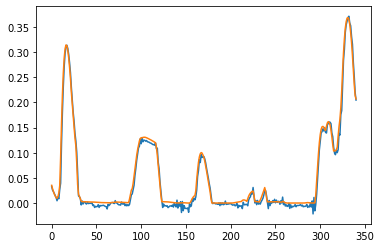

In [29]:
model.reset()

example_in, example_out = dataset[0]
example_len = example_in.shape[0]
out_dim = example_out.shape[1]
preds = torch.empty((example_len, out_dim))

for tidx in range(example_len):
    cur_in = example_in[tidx,:]
    cur_in = cur_in.reshape((1,) + cur_in.shape)
    pred = model(cur_in)
    preds[tidx, :] = pred[:]

plt.plot(preds[:,8].detach().numpy())
plt.plot(example_out[:,8])
print(preds.shape)
plt.show()